# Welcome back! Ideally, you have completed the ***QAS_Basics Notebook*** and have successfuly replicated the results. Now that were caught up on the basics of making and understanding spectra, lets dive head first into the code and ideas behind this project.


## Mainly the goal of this notebook will be about understanding *what* clouds are and our process of determining *how many* clouds may be present in a spectrum.

## The first point is easy enough to explain. Take a look at the manual for a more detailed definition. We assume that each spectrum (a.k.a. our line of sight) is composed of a certain number of clouds, *n_clouds*. Each cloud has its own unique parameters (for now were still just assuming logN, b, and v but this is about to get much more detailed and interesting in the next notebook). Therefore, these unique paramters will contribute a unique dip in the absorption spectrum. 

## Recall in our last notebook we made a single absorption dip - that is our cloud! Extreme word of warning: *The number of absorption dips DOES NOT EQUAL the number of clouds*. If that were the case, this project would be far more simple and less interesting!

### Lets look at what I mean! 

In [1]:
import numpy as np               # very versatile module that we will use frequently
import matplotlib.pyplot as plt  # module we will use for all our plotting!
from rbvfit import model as m    # tool that generates flux data from Dr. Rongmon Bordoloi 

In [2]:
# lets load our 1 cloud spectrum again to start
n_clouds = 1
logN = np.array([14.5])
b = np.array([8])
v = np.array([0])
params = np.concatenate((logN,b,v))

lambda_rest = np.array([1526.7066])
wave = np.arange(1524,1528,0.01)

In [7]:
zabs=np.array([0.0])
ntransition=len(lambda_rest)
s= m.create_voigt(zabs,lambda_rest,n_clouds,ntransition,FWHM = '6.5',verbose=True)
fnorm = s.model_flux(params,wave) + np.random.normal(0,0.06,len(wave)) #fnorm meaning normalized flux

Added line:SiII 1526 at z:0.0


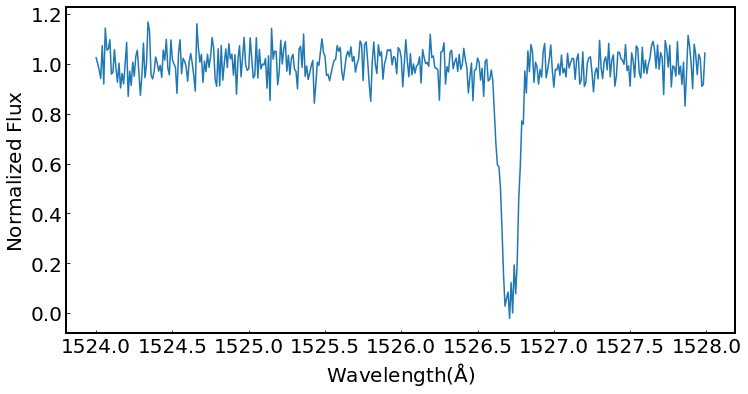

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
    
ax.plot(wave,fnorm,label='Mock Spectrum')
ax.set_ylabel(r'$\mathrm{Normalized\;Flux}$')
ax.set_xlabel(r'$\mathrm{Wavelength (\AA)}$')
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)  

In [11]:
# Cool now what happens if we set n_clouds to 2 and just duplicate all parameters?
n_clouds = 2
logN = np.array([14.5,14.5])
b = np.array([8.,8.])
v = np.array([0.,0.])
params_2 = np.concatenate((logN,b,v))

## Quick Important note now that its relevant. When feeding parameters into Dr. Bordoloi's code, your array must follow the format:
### parameter_array = [logN_1,logN_2,...logN_n, b_1,b_2,...b_n, v_1,v_2,...,v_n] with n being n_clouds

In [12]:
zabs=np.array([0.0])
ntransition=len(lambda_rest)
s= m.create_voigt(zabs,lambda_rest,n_clouds,ntransition,FWHM = '6.5',verbose=True)
fnorm_2 = s.model_flux(params_2,wave) + np.random.normal(0,0.06,len(wave))

Added line:SiII 1526 at z:0.0
Added line:SiII 1526 at z:0.0


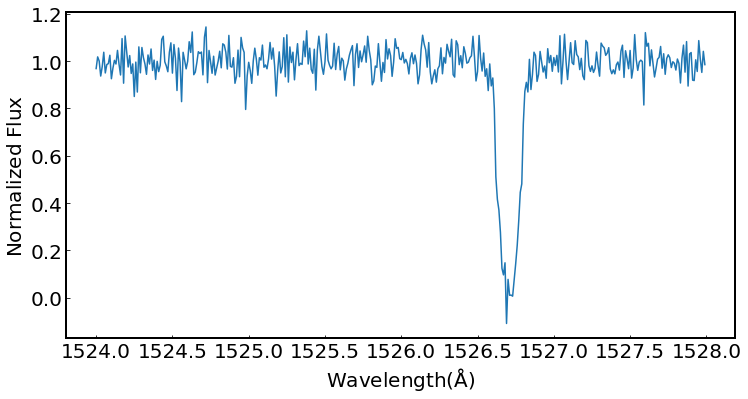

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
    
ax.plot(wave,fnorm_2,label='Mock Spectrum')
ax.set_ylabel(r'$\mathrm{Normalized\;Flux}$')
ax.set_xlabel(r'$\mathrm{Wavelength (\AA)}$')
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)  

# Well, where is it? This spectrum looks *identical* to the original one, but we have increased the number of clouds! No need to panic. This is an illustration of *why* counting the number of dips is not the best way to count the number of clouds. The 2 clouds are *on top of each other*. This is due to the fact that they have the same velocity. If we off set the velocity of one of the clouds we should see both.

In [20]:
n_clouds = 2
v = np.array([0.,-100.])
params_2 = np.concatenate((logN,b,v))

In [21]:
s= m.create_voigt(zabs,lambda_rest,n_clouds,ntransition,FWHM = '6.5',verbose=True)
fnorm_2_sep = s.model_flux(params_2,wave) + np.random.normal(0,0.06,len(wave))

Added line:SiII 1526 at z:0.0
Added line:SiII 1526 at z:0.0


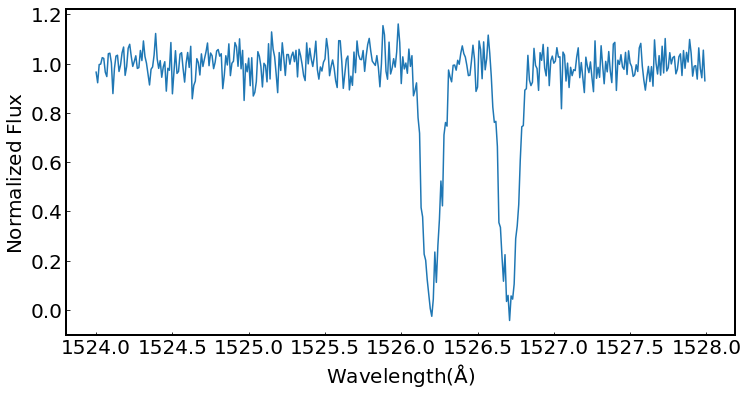

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
    
ax.plot(wave,fnorm_2_sep,label='Mock Spectrum')
ax.set_ylabel(r'$\mathrm{Normalized\;Flux}$')
ax.set_xlabel(r'$\mathrm{Wavelength (\AA)}$')
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)  

# Aha! There it is. Now with the burning question! *How* can we possibly tell when two clouds are on top of each other or if the absorption dip we see is really just one cloud's doing? Well thats the tricky part. Recall, when we sampled our 1 cloud absorption last notebook we saved the Bayesian Evidence. Lets see what happens if we sample this flux file for n_clouds = 1 and 2 then compare the evidence!

In [18]:
import dynesty

In [19]:
def prior_transform(utheta): #utheta will be the array of random numbers. The length of this array will be equal to n_clouds * number of parameters (3 params for now)
   
    ulogN = utheta[0:n_clouds] #breaks up the array into individual arrays for each parameters so we can transform them differently!
    ub = utheta[n_clouds:2*n_clouds]
    uv = utheta[2*n_clouds:3*n_clouds]

    logN_guess = 3. * ulogN  + 12.  # transforms bounds of logN from (0,1) to (12,15)
    b_guess =  20.* ub + 5.         # transforms bounds of b from (0,1) to (5,15)
    v_guess = 400.* uv - 200.      # transforms bounds of b from (0,1) to (-200,200)

    

    return np.concatenate([logN_guess, b_guess, v_guess])  

def lnlikelihood(theta): #this theta is just the array returned from the prior_transform
    model = s.model_flux(theta,wave) #creates the flux based off our guess parameters 
    inv_sigma2 = 1.0/(enorm**2 )
    all_c2_values = (data - model) ** 2 * inv_sigma2  - np.log(inv_sigma2) #checks how well our guess flux compares to the orignial and assigns it a "score"
    return -0.5 * (np.sum( all_c2_values  )) 

In [23]:
#define data to be the flux file were interested in
data = fnorm_2_sep
enorm = 0.02 * np.ones((len(wave)))

### Lets pretend we don't know there are 2 clouds and we want to blindy sample n _clouds = 1 and 2

In [24]:
n_clouds_guess = 1 
number_params = 3 # logN, b, v
ndim = number_params * n_clouds #sets how many random numbers dynesty will make
s= m.create_voigt(zabs,lambda_rest,n_clouds_guess,ntransition,FWHM = '6.5',verbose=True)

Added line:SiII 1526 at z:0.0


In [26]:
dsampler1 = dynesty.DynamicNestedSampler(lnlikelihood, prior_transform, ndim=number_params*n_clouds_guess, bound='multi', sample='auto')
dsampler1.run_nested()
dres1 = dsampler1.results

23478it [02:06, 185.05it/s, batch: 8 | bound: 91 | nc: 2 | ncall: 87937 | eff(%): 26.699 | loglstar: -13615.932 < -13609.007 < -13610.147 | logz: -13626.387 +/-  0.238 | stop:  0.925]   


In [54]:
# lets see how the evidence progressed with time
ev_1_arr = dres1.logz

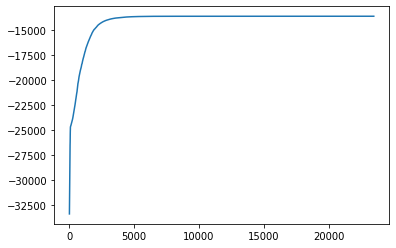

In [55]:
plt.plot(ev_1_arr)

(-13700.0, -13500.0)

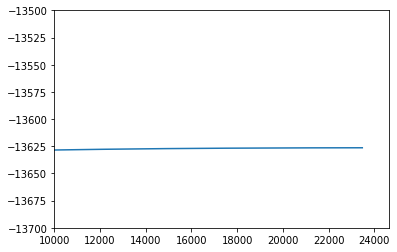

In [56]:
#as you can see it started out super low and then rapidly plateau'd we can zoom in as well
plt.plot(ev_1_arr)
plt.xlim(10000,)
plt.ylim(-13700,-13500)

In [57]:
#looks pretty flat, thats becuase at the end of the run, the sampler could not find a better guess. 
#Thus we say our evidence for the 1 cloud fit is the LAST evidnece prdouced (the one assosciated with the best fit)
ev_1 = dres1.logz[-1] #takes the last element of the array

In [36]:
print(ev_1)

-13626.386063883512


## Pretty low evidence, lets look at how the fit looks

In [37]:
samples1 = dres1.samples

In [47]:
guess1 = samples1[-1] #take the best guess (the last one)

In [48]:
guess_flux1 = s.model_flux(guess1,wave)

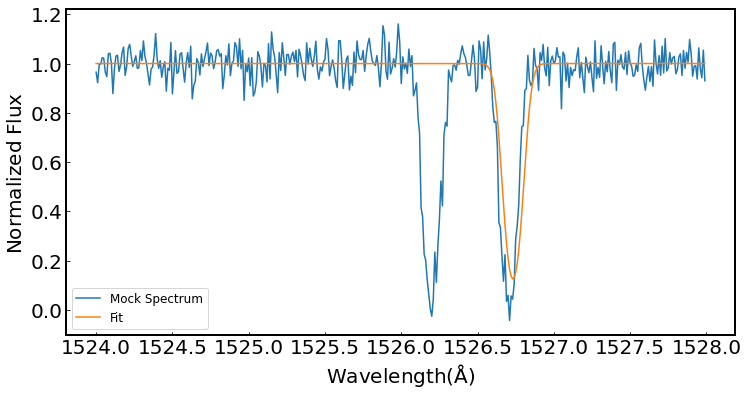

In [49]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(wave,data,label='Mock Spectrum')
ax.plot(wave,guess_flux1,label='Fit')

ax.set_ylabel(r'$\mathrm{Normalized\;Flux}$')
ax.set_xlabel(r'$\mathrm{Wavelength (\AA)}$')
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
ax.legend(fontsize = 12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)   

# Pretty poor fit. This explains the low evidence. Lets see how a 2 cloud fit looks. 

In [50]:
n_clouds_guess = 2 
number_params = 3 # logN, b, v
ndim = number_params * n_clouds #sets how many random numbers dynesty will make
s= m.create_voigt(zabs,lambda_rest,n_clouds_guess,ntransition,FWHM = '6.5',verbose=True)

Added line:SiII 1526 at z:0.0
Added line:SiII 1526 at z:0.0


In [51]:
dsampler2 = dynesty.DynamicNestedSampler(lnlikelihood, prior_transform, ndim=number_params*n_clouds_guess, bound='multi', sample='auto')
dsampler2.run_nested()
dres2 = dsampler2.results
#note the longer run time. This is because we are now sampling with 6 dimensions and not 3

27740it [03:32, 130.56it/s, batch: 7 | bound: 180 | nc: 16 | ncall: 166336 | eff(%): 16.677 | loglstar: -113.660 < -106.641 < -108.130 | logz: -134.397 +/-  0.310 | stop:  0.909]          


In [52]:
ev_2_arr = dres2.logz

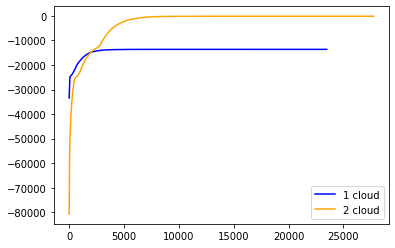

In [60]:
plt.plot(ev_1_arr,color='blue',label="1 cloud")
plt.plot(ev_2_arr,color='orange',label='2 cloud')
plt.legend()

## Hopefully its clear to see that the 2 cloud sample has a much higher evidence! This is cool! 
## We have some arbrtiary tool that can aid us in finding the correct number of clouds! Lets see how our 2 cloud fit looks 

In [63]:
guess2 = dres2.samples[-1]
guess_flux2 = s.model_flux(guess2,wave)

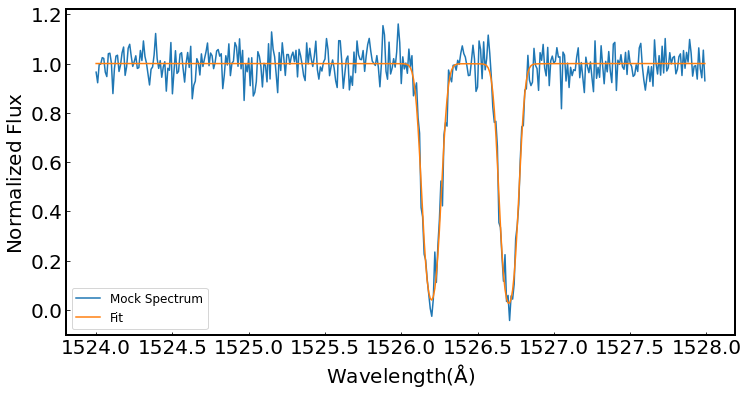

In [64]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(wave,data,label='Mock Spectrum')
ax.plot(wave,guess_flux2,label='Fit')

ax.set_ylabel(r'$\mathrm{Normalized\;Flux}$')
ax.set_xlabel(r'$\mathrm{Wavelength (\AA)}$')
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
ax.legend(fontsize = 12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)   

# And the fit is perfect! Seems like this works for this spectrum! WHat about when we have 2 clouds that are close together?

In [73]:
n_clouds = 2
logN = np.array([14.5,13.2])
b = np.array([8.,12.])
v = np.array([0.,20.])
params = np.concatenate((logN,b,v))

In [74]:
s= m.create_voigt(zabs,lambda_rest,n_clouds,ntransition,FWHM = '6.5',verbose=True)
fnorm_close = s.model_flux(params,wave) + np.random.normal(0,0.06,len(wave))

Added line:SiII 1526 at z:0.0
Added line:SiII 1526 at z:0.0


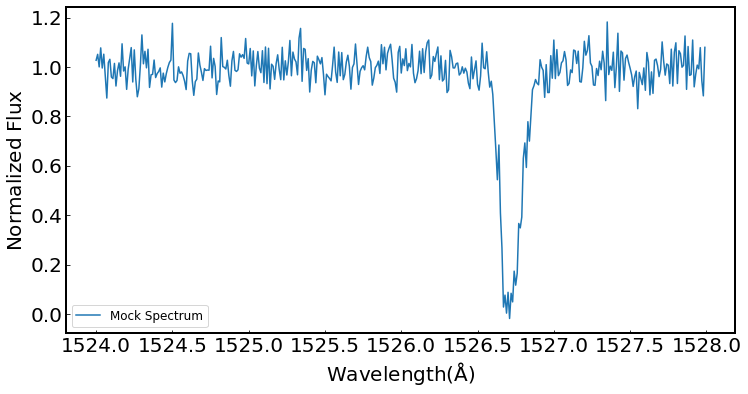

In [75]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(wave,fnorm_close,label='Mock Spectrum')


ax.set_ylabel(r'$\mathrm{Normalized\;Flux}$')
ax.set_xlabel(r'$\mathrm{Wavelength (\AA)}$')
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
ax.legend(fontsize = 12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20) 

# Re Sample

In [78]:
data = fnorm_close

In [79]:
n_clouds_guess = 1 
number_params = 3 # logN, b, v
ndim = number_params * n_clouds #sets how many random numbers dynesty will make
s= m.create_voigt(zabs,lambda_rest,n_clouds_guess,ntransition,FWHM = '6.5',verbose=True)

Added line:SiII 1526 at z:0.0


In [80]:
dsampler1 = dynesty.DynamicNestedSampler(lnlikelihood, prior_transform, ndim=number_params*n_clouds_guess, bound='multi', sample='auto')
dsampler1.run_nested()
dres1 = dsampler1.results

22754it [02:01, 187.51it/s, batch: 8 | bound: 80 | nc: 2 | ncall: 77938 | eff(%): 29.195 | loglstar: -611.200 < -604.523 < -605.704 | logz: -620.110 +/-  0.226 | stop:  0.972]         


In [83]:
ev_1 = dres1.logz[-1]
print(ev_1)

-620.1142238371485


# hmmm. Still pretty low evidence, but much higher than the previous 1 cloud sample. This is still a 2 cloud flux, so what gives?

In [85]:
guess1 = dres1.samples[-1]
guess_flux1 = s.model_flux(guess1,wave)

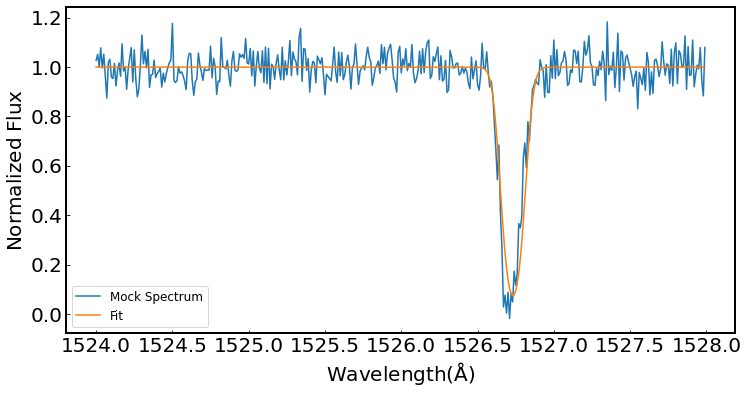

In [86]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(wave,fnorm_close,label='Mock Spectrum')
ax.plot(wave,guess_flux1,label='Fit')


ax.set_ylabel(r'$\mathrm{Normalized\;Flux}$')
ax.set_xlabel(r'$\mathrm{Wavelength (\AA)}$')
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
ax.legend(fontsize = 12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20) 

# Looks like the one cloud fit did a prert good job, even though the number of clouds is 2. Is this a cause for concern? Lets check the 2 cloud sample first.

In [87]:
n_clouds_guess = 2 
number_params = 3 # logN, b, v
ndim = number_params * n_clouds #sets how many random numbers dynesty will make
s= m.create_voigt(zabs,lambda_rest,n_clouds_guess,ntransition,FWHM = '6.5',verbose=True)

Added line:SiII 1526 at z:0.0
Added line:SiII 1526 at z:0.0


In [88]:
dsampler2 = dynesty.DynamicNestedSampler(lnlikelihood, prior_transform, ndim=number_params*n_clouds_guess, bound='multi', sample='auto')
dsampler2.run_nested()
dres2 = dsampler2.results

29471it [04:31, 108.53it/s, batch: 8 | bound: 257 | nc: 2 | ncall: 236205 | eff(%): 12.477 | loglstar: -204.061 < -195.656 < -196.642 | logz: -218.071 +/-  0.270 | stop:  0.996]         


In [89]:
ev_2 = dres2.logz[-1]
print(ev_2)

-218.0609452235698


In [90]:
guess2 = dres2.samples[-1]
guess_flux2 = s.model_flux(guess2,wave)

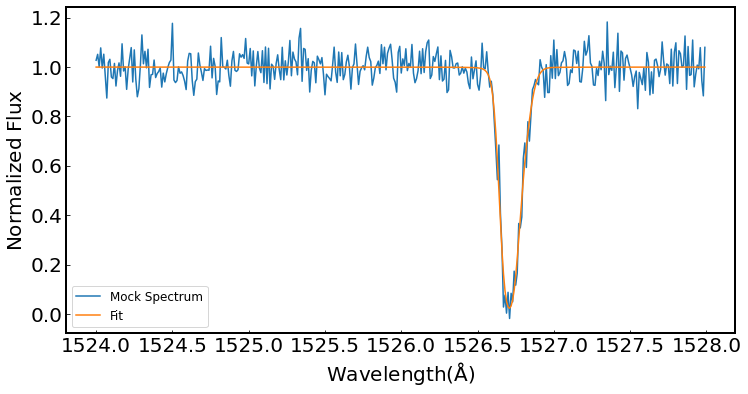

In [91]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(wave,fnorm_close,label='Mock Spectrum')
ax.plot(wave,guess_flux2,label='Fit')


ax.set_ylabel(r'$\mathrm{Normalized\;Flux}$')
ax.set_xlabel(r'$\mathrm{Wavelength (\AA)}$')
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
ax.legend(fontsize = 12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20) 

# So the 2 cloud still reigns supreme. However it was much closer with the 2 clouds being closer to one another (blended). Another comparison tool we can use is to look at the estimated TOTAL Column Density.

In [93]:
#recall the logN params we used for this
logN = np.array([14.5,13.2])

In [117]:
N = (10**(logN)) #need to do this so we can add
print (N)

[3.16227766e+14 1.58489319e+13]


In [98]:
total_N = np.sum(N) #adds the elements of an array
print(total_N)

332076697941449.06


In [100]:
total_logN = np.log10(total_N)
print(total_logN)

14.521238401914255


In [101]:
# Now lets see the estimated logNs from our two samples

In [106]:
total_logN_1 = guess1[0] #since theres only 1 value for logN (1 cloud) no addistion required, first element of guess array
print(total_logN_1)

14.198422936616495


In [109]:
logN_2_arr = guess2[0:2]
print(logN_2_arr) #Now we need to add again since there are two value of logN

[13.74989713 14.98415649]


In [114]:
#combine into one line of code
total_N_2 = np.sum(10**(logN_2_arr))
total_N_2

1020397194248025.5

In [115]:
total_logN_2 = np.log10(total_N_2)
print(total_logN_2)

15.008769255774409


# So our 1 cloud fit under-estimated the total column density while out 2 cloud fit over estimated. 